# Dog Breed Classifier
This is a model used to classify different dog breeds. The dataset used to train the model contains 70 different dog breeds.

In [116]:
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

Before we can start working with our data we need to extract the data.zip file. This is required to run the project on Google Colab.

In [117]:
file_name = 'data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Complete')

Complete


Once the zip file is extracted we can read in our dataset. We have 70 classes split in train, validation and test directories. We will be using the train directory to train our model and the test directory to validate our model.

In [118]:
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/test'
                
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# required for data augmentation
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True
)

train_dataset = data_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_dataset = data_generator.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [119]:
classes_labels = train_dataset.class_indices
classes_labels = dict((v,k) for k,v in classes_labels.items())
classes_labels = [classes_labels[i] for i in range(len(classes_labels))]
print(classes_labels)

['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


## Data overview

As previously mentioned our dataset contains dog breeds of 70 different classes. This can be tested with the below cell.

In [120]:
print(f"Dataset contains a total of {len(train_dataset.class_indices)} classes.")


Dataset contains a total of 70 classes.


Our images are RGB images and have the dimensions of 224x224 which is very common for image classification models.

In [121]:
for image_batch, label_batch in train_dataset:
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 70)


Below we can see a couple examples of the different classes. The images are all of the same shape.

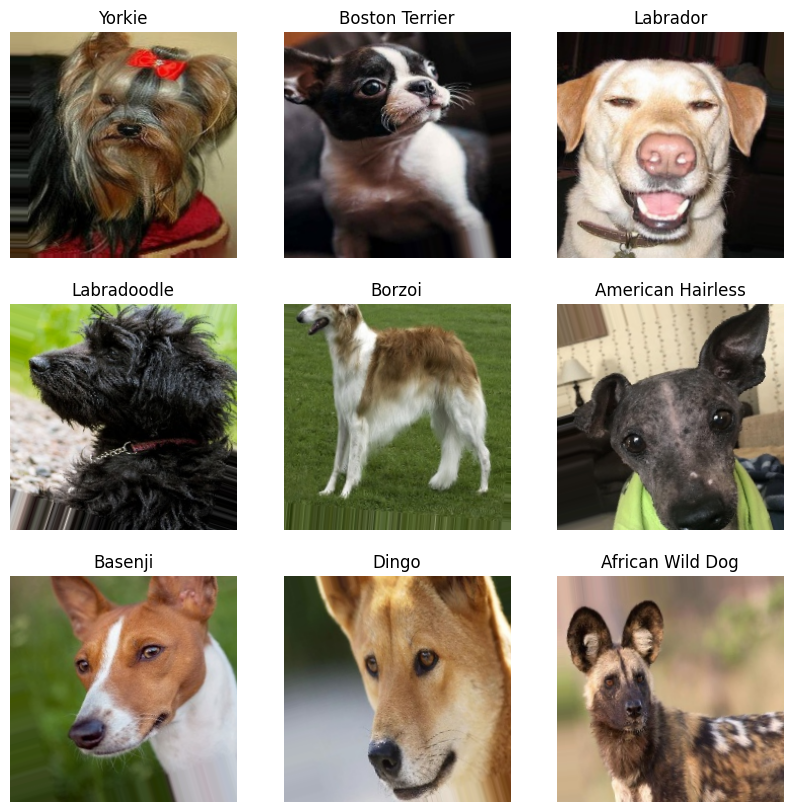

In [122]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.axis('off')
    label = label_batch[i].argmax()
    plt.title(list(train_dataset.class_indices.keys())[label])
plt.show()


## Building and training a model

Next we can start building our model. We will use mobilenetv2 as our base model and add a classification layer on top of it. Because we want to use the existing weights from the basemodel we want to freeze these weights so our model is only training on our new layer.

In [123]:
pre_processing = tf.keras.Sequential([tf.keras.layers.Input((224,224,3)),
                             tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)])

mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape = (224,224,3), 
                                                 include_top = False)
mobilenet_v2.trainable = False  # Freeze MobileNetV2 layers

classifier = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(70, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))])

dog_classifier_mobile = tf.keras.Sequential([pre_processing, 
                                             mobilenet_v2,
                                             classifier])

Now that our model is created we can define an optimizer and compile our model.

In [124]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

dog_classifier_mobile.compile(optimizer = opt, 
                              loss = 'categorical_crossentropy', 
                              metrics = ['accuracy'])

Next we want to build it and create a summary. We can see that our model has a preprocessing layer, the whole mobilenetv2 with all it's layers and our own sequential classification layer.

In [125]:
dog_classifier_mobile.build(((None, 224, 224, 3)))
dog_classifier_mobile.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential_25 (Sequential)  (None, 70)                89670     
                                                                 
Total params: 2,347,654
Trainable params: 89,670
Non-trainable params: 2,257,984
_________________________________________________________________


To reduce overfitting we define an early stopping callback. Once this is done we can train our model. To reduce computational time we will train our model with 10 epochs.

In [126]:
epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='min', restore_best_weights=False)

history = dog_classifier_mobile.fit(train_dataset, 
                                    validation_data = val_dataset, 
                                    epochs = epochs, 
                                    callbacks=[early_stopping])

Epoch 1/10
249/249 [==============================] - 81s 319ms/step - loss: 5.0379 - accuracy: 0.1350 - val_loss: 3.8414 - val_accuracy: 0.5186
Epoch 2/10
249/249 [==============================] - 48s 192ms/step - loss: 3.4891 - accuracy: 0.4734 - val_loss: 2.7200 - val_accuracy: 0.7843
Epoch 3/10
249/249 [==============================] - 48s 193ms/step - loss: 2.6911 - accuracy: 0.6668 - val_loss: 2.1736 - val_accuracy: 0.8543
Epoch 4/10
249/249 [==============================] - 47s 190ms/step - loss: 2.2667 - accuracy: 0.7473 - val_loss: 1.8484 - val_accuracy: 0.8943
Epoch 5/10
249/249 [==============================] - 48s 192ms/step - loss: 1.9696 - accuracy: 0.8017 - val_loss: 1.6172 - val_accuracy: 0.9229
Epoch 6/10
249/249 [==============================] - 48s 193ms/step - loss: 1.7820 - accuracy: 0.8238 - val_loss: 1.4725 - val_accuracy: 0.9100
Epoch 7/10
249/249 [==============================] - 48s 191ms/step - loss: 1.6307 - accuracy: 0.8400 - val_loss: 1.3326 - val_ac

# Model evaluation

During the training of the model a total of 10 of epochs were performed to optimize the model's performance. The training started with an initial loss of 5.0839 and an accuracy of 0.1172. After 10 epochs, the final loss decreased to 1.3228, while the accuracy increased to 0.8710. The validation loss further decreased to 1.0883, and the validation accuracy reached 0.9343. These improvements indicate that the model effectively learned to classify the images in the dataset. During the training, there was a decrease in both loss and validation loss. This means that the model was learning and making more accurate predictions as the training progressed and did not overfit.

The validation accuracy of 0.9343 in the last epoch shows that the model was able to handle unseen data well. This means the model can effectively classify new images with a high degree of confidence.

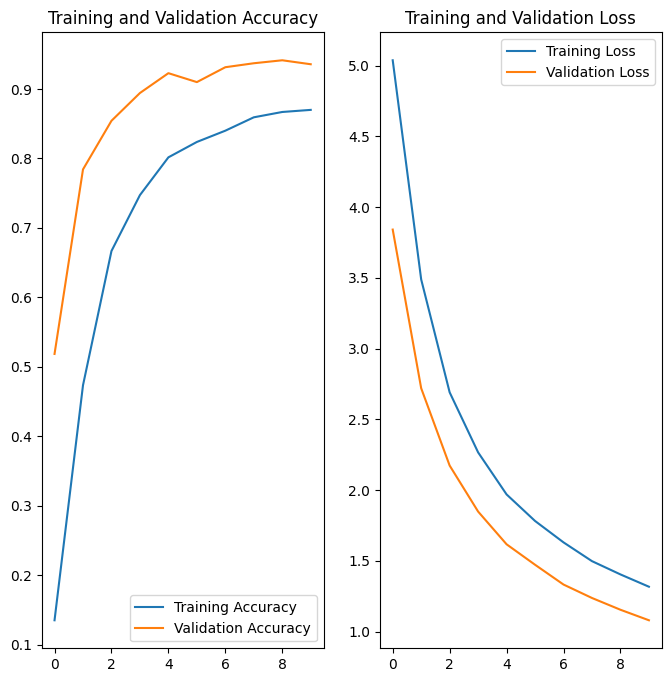

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Making predictions

Using the `save()` function we can save the model. To better organize the project we save the output in the *models* folder.

In [128]:
dog_classifier_mobile.save('models/dog_classifier_mobile.h5')

To make predictions we load the model again using the `load_model()` function. Once the model is loaded we can try and make a prediction.

In [129]:
import numpy as np

model = tf.keras.models.load_model('models/dog_classifier_mobile.h5')
dog_path = 'data/test/Afghan/01.jpg'

img = tf.keras.utils.load_img(
    dog_path, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"This dog is a {classes_labels[np.argmax(score)]}.")

1/1 [==============================] - 0s 487ms/step
This dog is a Afghan.
